In [5]:
def load_samples():
    '''
    load training data from the .csv file
    '''
    samples = []
    with open('data/driving_log.csv') as csv_file:
        reader = csv.reader(csv_file)
        for sample in reader:
            samples.append(sample)

    # Pop the first item on the list to get rid of list headers
    samples.pop(0)
    return samples

def pre_process(sample, idx, new_cols, new_rows, cropped_pixels_x, cropped_pixels_y, channels):
    '''
    pre-process each incoming image
    '''
    source_path = sample[idx]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    img = Image.open(current_path)
    
    return image_preprocessing(img, new_cols, new_rows, cropped_pixels_x, cropped_pixels_y, channels)

def image_preprocessing(img, new_cols, new_rows, cropped_pixels_x, cropped_pixels_y, channels):
    '''
    conver to HSV, crop and resize
    '''
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)[cropped_pixels_x:cropped_pixels_y,:,channels]
    img = cv2.resize((img),(new_cols,new_rows))
    return img

def load_arrays(samples, X, y, new_cols, new_rows, steering_correction, cropped_pixels_x, cropped_pixels_y, channels):
    '''
    Load images from the folder using preloaded image file names form the CSV file
    Break it down into three groups: center camera image, left camera image and right samera image
    Create two arrays with image data. X array will hold image data. 
    Before appending image data to X array it will be pre processed with `def pre_process()` function.
    `y` array will contain stearing information and will be same for all three images.
    '''
    print("Loading data...")

    for sample in samples:
        # central camera
        X.append(pre_process(sample, 0, new_cols, new_rows, cropped_pixels_x, cropped_pixels_y, channels))
        y.append(float(sample[3]))

        # left camera
        X.append(pre_process(sample, 1, new_cols, new_rows, cropped_pixels_x, cropped_pixels_y, channels))
        y.append(float(sample[3]) + steering_correction)
        
        # right camera
        X.append(pre_process(sample, 2, new_cols, new_rows, cropped_pixels_x, cropped_pixels_y, channels))
        y.append(float(sample[3]) - steering_correction)

    X = np.array(X)
    y = np.array(y)

    print("Training Data Size: ", X.shape, y.shape)
    print("Loading data complete")
    return X, y

def flip_images(X, y):
    '''
    flip the image data horizontally and append the new data to the training data
    negate the steering wheel angles of the flipped images
    '''
    X = np.concatenate([X, X[:,:,::-1]])
    y = np.concatenate([y, -y])
    return X, y

def shuufle_data(X, y):
    '''
    shuffle the training data
    '''
    X, y = sk_shuffle(X, y)

    X_train = X[:,:,:,None]
    y_train = y[:]

    print("Training Data Size: ", X_train.shape, y_train.shape)
    print("Loading data complete")
    print("Flipping and shuffling of data complete")
    return X_train, y_train

def show_sample(samples):
    source_path = samples[10][0]

    filename = source_path.split('/')[-1]
    img = Image.open('data/IMG/' + filename)
    img1 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)[cropped_pixels_x:cropped_pixels_y,:,channels]
    img3 = cv2.resize((img1),(new_cols,new_rows)) 

    plt.subplot(2,2,1)
    plt.imshow(img, interpolation='none')
    plt.title("original image")
    plt.subplot(2,2,2)
    plt.imshow(img1, interpolation='none')
    plt.title("cropped image")
    plt.subplot(2,2,3)
    plt.imshow(img3, interpolation='none')
    plt.title("cropped resized")
    plt.subplot(2,2,4)
    plt.imshow(img3, cmap='gray')
    plt.title("cropped resized greyscale")

    plt.show()

def create_model(new_rows, new_cols):
    '''
    Model design
    '''
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(new_rows, new_cols, 1), name='Normalization'))
    model.add(Conv2D(2, 1, 1, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((4, 4), (4, 4), 'same'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))

    model.summary()
    return model

def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save("model.h5")
    print("Saved model to disk")

In [6]:
import csv
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
from keras.models import Sequential
from keras.layers import Lambda, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from keras.models import model_from_json
print("Imports complete")

cropped_pixels_x = 40 
cropped_pixels_y = -10
channels = 1
new_rows = 25
new_cols = 65
# amount of steering wheel angle correction applied
# to images from the left and the right cameras
steering_correction = 0.275
batch_size = 128
X, y = [], []
print("Parameters set")

samples = load_samples()
print("Loaded samples")

Imports complete
Parameters set
Loaded samples


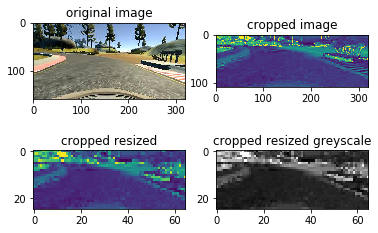

Displaying examples of processed images


In [7]:
show_sample(samples)
print("Displaying examples of processed images")

In [4]:
X, y = load_arrays(samples, X, y, new_cols, new_rows, steering_correction, cropped_pixels_x, cropped_pixels_y, channels)
X, y = flip_images(X, y)
X_train, y_train = shuufle_data(X, y)
model = create_model(new_rows, new_cols)

# Compile the model
model.compile(loss='mean_squared_error',optimizer='adam')

# Train the model on the training data with 25 epochs
model.fit(X_train, y_train, batch_size=batch_size, verbose=1, validation_split=0.1, nb_epoch=25,shuffle=True)
save_model(model)

Loading data...
('Training Data Size: ', (24108, 25, 65), (24108,))
Loading data complete
('Training Data Size: ', (48216, 25, 65, 1), (48216,))
Loading data complete
Flipping and shuffling of data complete
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalization (Lambda)           (None, 25, 65, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 23, 63, 2)     20          Normalization[0][0]              
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 5, 15, 2)      0           convolution2d_1[0][0]            
______________________________________________________________________________________